Good day.

Let's say, we're working for an insurance company, and two brothers - Ben & Jerry - would like to buy a health insurance.

We'll build a model to predict:

What are chances that Ben and Jerry are claimers?
How much money can we possibly lose on each of them?
Spoiler alert:

Ben will be a claimer (probability 99%), with potential charges 17 425 USD (+/- $4 587 USD error, accuracy 0,84); Jerry will be a claimer (probability 1 percent), potential charges 2 572 USD.
Also, just for fun, we're going to visualize data to reflect a portrait of current customers.

In [2]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

#machine learnong
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve
import pylab as pl

#reading the file
#df = pd.read_csv('//kaggle/input/sample-insurance-claim-prediction-dataset/insurance3r2.csv')
df = pd.read_csv('insurance3r2.csv')

STEP 1 - Discovering data

(1338, 9)
Index(['age', 'sex', 'bmi', 'steps', 'children', 'smoker', 'region', 'charges',
       'insuranceclaim'],
      dtype='object')


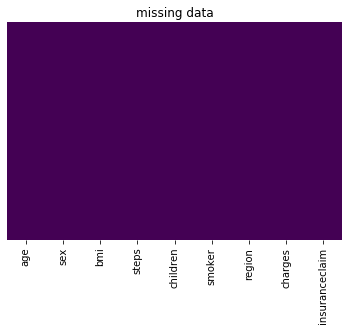

In [4]:
print(df.shape)
print(df.columns)

sns.heatmap(df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title('missing data')
plt.show()

Result: 1338 rows, 9 columns; there is no missing data  
STEP 2 - exploratory data analysis

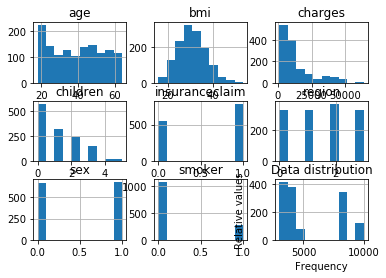

In [5]:
df.hist()
plt.title('Data distribution')
plt.xlabel('Frequency')
plt.ylabel('Relative values')
plt.show()

Looks like there are some ouliers in bmi; cheking them out:

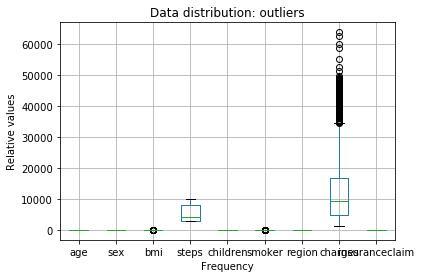

In [6]:
df.boxplot()
plt.title('Data distribution: outliers')
plt.xlabel('Frequency')
plt.ylabel('Relative values')
plt.show()

Looks like 'charges' as well has outliers above 50 000, let's see in detail:

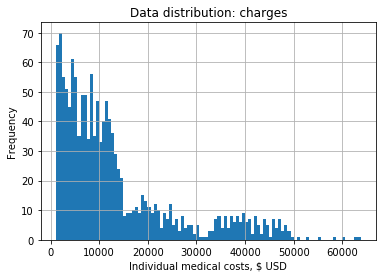

(7, 9)


In [7]:
df.hist(column='charges', bins=100)
plt.title('Data distribution: charges')
plt.xlabel('Individual medical costs, $ USD')
plt.ylabel('Frequency')
plt.show()
charges_outliers = df.loc[df.charges >= 50000]
print(charges_outliers.shape) 

We accept outliers like a positive ones. Let's check column 'steps' - there are some obviously groups:

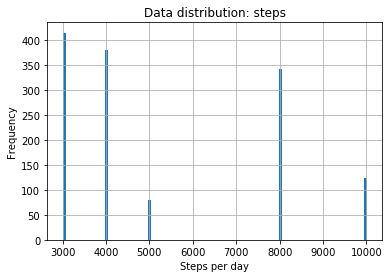

In [8]:
df.hist(column='steps', bins=100)
plt.title('Data distribution: steps')
plt.xlabel('Steps per day')
plt.ylabel('Frequency')
plt.show()

There are no outliers, but let's round groups to 3000, 4000, 5000, 8000, 10000 for a nicer overview:

In [9]:
decimals = -3
df['steps']=df['steps'].apply(lambda x: round(x, decimals))
print(df.steps.value_counts())

3000     414
4000     380
8000     342
10000    123
5000      79
Name: steps, dtype: int64


STEP 3 - visualization

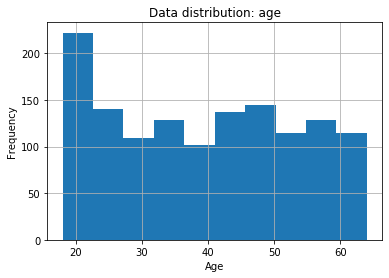

In [10]:
df.hist(column='age', bins=10)
plt.title('Data distribution: age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

There are some certain age groups that we can spot to visualize:

In [11]:
a = df
a['age'] = a['age'].mask(a['age'] <= 20, 1)
a['age'] = a['age'].mask(
    (a['age'] >= 21) & (a['age'] <= 30), 2)
a['age'] = a['age'].mask(
    (a['age'] >= 31) & (a['age'] <= 40), 3)
a['age'] = a['age'].mask(
    (a['age'] >= 41) & (a['age'] <= 50), 4)
a['age'] = a['age'].mask(
    (a['age'] >= 51) & (a['age'] <= 60), 5)
a['age'] = a['age'].mask(a['age'] >= 61, 6)
unique, counts = np.unique(a.age, return_counts=True)

How old are our customers?

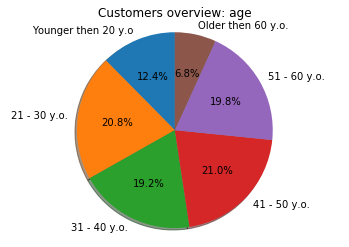

In [12]:
labels = 'Younger then 20 y.o', '21 - 30 y.o.', '31 - 40 y.o.', '41 - 50 y.o.', '51 - 60 y.o.', 'Older then 60 y.o.'
sizes = [166, 278, 257, 281, 265, 91]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.title('Customers overview: age')
plt.show()

Do we have more male clients?

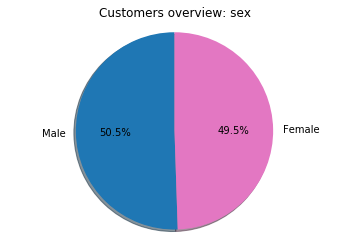

In [13]:
labels = 'Male', 'Female'
sizes = [676, 662]
colors = ['tab:blue', 'tab:pink']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.title('Customers overview: sex')
plt.show()

How much smokers do we have?

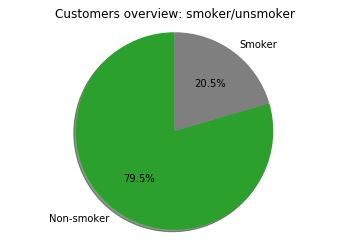

In [14]:
labels = 'Non-smoker', 'Smoker'
sizes = [1064, 274]
colors = ['tab:green', 'tab:gray']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.title('Customers overview: smoker/unsmoker')
plt.show()

How often do our customers claim?

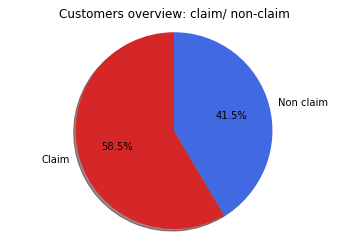

In [16]:
labels = 'Claim', 'Non claim'
sizes = [783, 555]
colors = ['tab:red', 'royalblue']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.title('Customers overview: claim/ non-claim')
plt.show()

Conclusion: we did make some visualization to understand our customers portrait. Time to build a predicion model.

STEP 4 - Features discovering

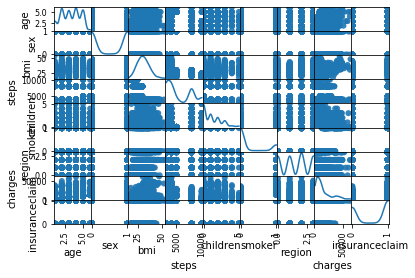

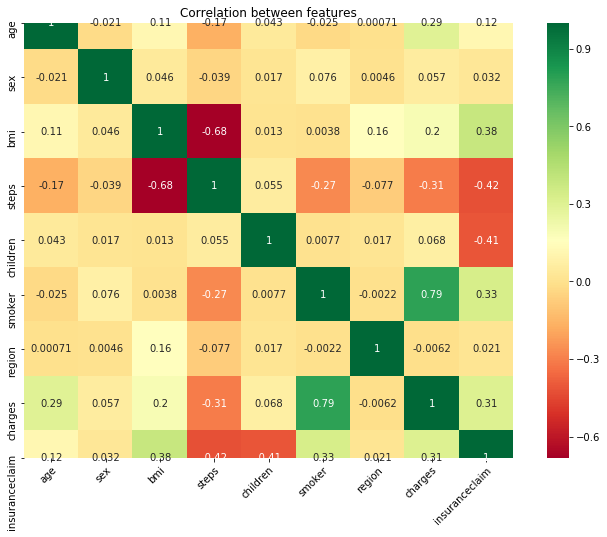

In [18]:
scatter_matrix(df, alpha=0.9, diagonal="kde",marker="o")
plt.show() 
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df.corr(), square=True, cmap='RdYlGn', annot=True, mask=None)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor") 
plt.title('Correlation between features')
plt.show()

Here, we've spotted some correlation - age is positive correlated with charges, bmi - negative with steps, bmi - positive with charges, steps - negative with charges (that is make sence completely).

STEP 5 - Building a model

In [19]:
X = df.drop(['insuranceclaim'], axis=1).values
y = df['insuranceclaim'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (936, 8)
X_test : (402, 8)
y_train : (936,)
y_test : (402,)


We're going to use ROC curves to choose the classifier:

In [22]:
import ml_metrics

ModuleNotFoundError: No module named 'ml_metrics'

In [23]:
models = []
models.append(RandomForestClassifier(n_estimators=165, max_depth=4, criterion='entropy'))
models.append(GradientBoostingClassifier(max_depth =4))
models.append(KNeighborsClassifier(n_neighbors=20))
models.append(GaussianNB())
plt.figure(figsize=(10, 10)) 
for model in models:
    model.fit(X_train, y_train)
    pred_scr = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, pred_scr)
    roc_auc = ml_metrics.auc(y_test, pred_scr)
    md = str(model)
    md = md[:md.find('(')]
    pl.plot(fpr, tpr, label='ROC fold %s (auc = %0.2f)' % (md, roc_auc))
pl.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
pl.xlim([0, 1])
pl.ylim([0, 1])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic example')
pl.legend(loc="lower right")
pl.show()

NameError: name 'ml_metrics' is not defined

<Figure size 720x720 with 0 Axes>

As we can see, the best score - GradientBoostingClassifier (the largest area under the ROC curve), our model has accuracy score R^2 is about 99%.

STEP 6 - Test the model
Making a simple test:

Our potential customers:

Ben: age 19, male, bmi 27.9, steps 3000 per day, no children, smoker, North-West, charges last year 16 885 USD,
Jerry: age 23, male, bmi 24.3, steps 6000 per day, no children, non-smoker, North-West, charges last year 2 137 USD,
To predict if it'll be a claim:

In [24]:
Ben_Jerry_test = [[1, 0, 27.900, 3000, 0, 1, 3, 16885], [1, 0, 24.3, 6000, 0, 0, 3, 2137]]
df_Ben_Jerry = pd.DataFrame(Ben_Jerry_test)
clf = GradientBoostingClassifier(max_depth =4)
clf.fit(X_train, y_train)
Ben_Jerry_prediction = clf.predict(df_Ben_Jerry)
print('Prediction (1 - claim, 0 - no-claim) {}'.format(Ben_Jerry_prediction))

Prediction (1 - claim, 0 - no-claim) [1 0]


Result: Ben will be a claimer, Jerry - no, with probability 99%

STEP 7 - Building model to predict charges

Linear Regression R^2: 0.7739
Ridge Regression R^2: 0.7192
Lasso Regression R^2: 0.7741
Random Forest R^2: 0.8442
Linear Regression RMSE: 5757.62
Ridge Regression RMSE: 6416.32
Lasso Regression RMSE: 5755.3
Random Forest RMSE: 4847.5
               Model     R^2     RMSE
0  Linear Regression  0.7739  5757.62
1   Ridge Regression  0.7192  6416.32
2   Lasso Regression  0.7741  5755.30
3      Random Forest  0.8442  4847.50


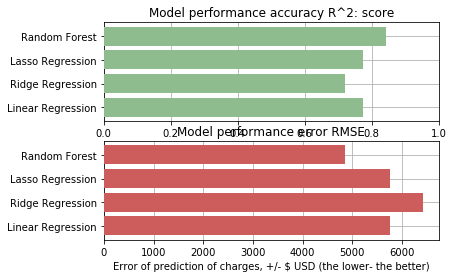

In [26]:
X = df.drop(['insuranceclaim', 'charges'] , axis=1).values
y = df['charges'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

LinearRegression = LinearRegression()
Ridge = Ridge(alpha = 0.3, normalize=True)
Lasso = Lasso(alpha=0.6, normalize=True)
RandomForest = RandomForestRegressor(n_estimators=100)

def calculate_R2(model, model_name):
    model.fit(X_train, y_train)
    y_pred =  model.predict(X_test)
    R2 = model.score(X_test, y_test).round(4)
    print(model_name, 'R^2: {}' .format(R2))
    return R2

LinearRegression_R2 = calculate_R2(LinearRegression, 'Linear Regression')
Ridge_R2 = calculate_R2(Ridge, 'Ridge Regression')
Lasso_R2 = calculate_R2(Lasso, 'Lasso Regression')
RandomForest_R2 = calculate_R2(RandomForest, 'Random Forest')

 
def calculate_RMSE(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred)).round(2)
    print(model_name, "RMSE: {}".format(RMSE))
    return RMSE
   
LinearRegression_RMSE = calculate_RMSE(LinearRegression, 'Linear Regression')
Ridge_RMSE = calculate_RMSE(Ridge, 'Ridge Regression')
Lasso_RMSE = calculate_RMSE(Lasso, 'Lasso Regression')
RandomForest_RMSE = calculate_RMSE(RandomForest, 'Random Forest')
df_R2_RMSE = pd.DataFrame(
    {
        'Model':['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Random Forest'], 
        'R^2':[LinearRegression_R2, Ridge_R2, Lasso_R2, RandomForest_R2], 
        'RMSE':[LinearRegression_RMSE, Ridge_RMSE, Lasso_RMSE,RandomForest_RMSE]
    }
)
print(df_R2_RMSE)
# #result visualization
x = range(df_R2_RMSE.shape[0])
plt.subplot(2,1,1)
R2 = plt.barh(x, df_R2_RMSE['R^2'], color=('darkseagreen'), zorder=3)
plt.xlabel('Score, 1 = 100% (the higher - the better)')
plt.yticks(x, df_R2_RMSE['Model'])
plt.title('Model performance accuracy R^2: score')
plt.grid(zorder=0)
plt.xlim(0, 1)
plt.subplot(2,1,2)
RMSE =plt.barh(x, df_R2_RMSE['RMSE'], color=('indianred'), zorder=3)
plt.xlabel('Error of prediction of charges, +/- $ USD (the lower- the better)')
plt.yticks(x, df_R2_RMSE['Model'])
plt.title('Model performance error RMSE')
plt.grid(zorder=0)
plt.show()

Result: Best performance - Random Forest classifier, with accuracy score R^2 = 85,4%, RMSE: +/- 4587 USD

Running a test on our brothers:

In [27]:
Ben_Jerry_test_charges = [[1, 0, 27.900, 3000, 0, 1, 3], [1, 0, 24.3, 6000, 0, 0, 3]]
df_Ben_Jerry_charges = pd.DataFrame(Ben_Jerry_test_charges)
clf = RandomForest
clf.fit(X_train, y_train)
prediction_chages = clf.predict(df_Ben_Jerry_charges)
print('Prediction {}'.format(prediction_chages))

Prediction [17695.3117267  2736.4851675]


Result: Ben's possible charges are 17 151 USD, Jerry's - 2 572 USD, with error +/- 4587 USD and accuracy score of the model 84%.

Hope, it was interesting. Thank you for reading.